# Testing your causal graph

## Purpose
This notebook describes and demonstrates methods for testing the assumptions of one's causal graph.
We test three types of assumptions:
- marginal independence assumptions,
- conditional independence assumptions, and
- latent, conditional independence assumptions.

For each assumption, we first describe the logic used to test it.
Then, we demonstrate one mechanism for testing the assumption according to that logic.


## Set notebook parameters

In [1]:
# Declare paths to data
DATA_PATH = "../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv"
# Note that these files are based on using the PPCA model
# of Wang and Blei (2018). W represents global factor
# coefficients and Z represents latent factor loadings
PATH_TO_W_PARAMS = "../../data/processed/W_inferred_PPCA.csv"
PATH_TO_Z_PARAMS = "../../data/processed/Z_inferred_PPCA.csv"

# Note the columns of interest for this notebook
MODE_ID_COLUMN = "mode_id"
OBS_ID_COLUMN = "observation_id"

TIME_COLUMN = "total_travel_time"
COST_COLUMN = "total_travel_cost"
DISTANCE_COLUMN = "total_travel_distance"
LICENSE_COLUMN = "num_licensed_drivers"
NUM_AUTOS_COLUMN = "num_cars"

UTILITY_COLUMNS = [
    TIME_COLUMN,
    COST_COLUMN,
    DISTANCE_COLUMN,
    LICENSE_COLUMN,
    NUM_AUTOS_COLUMN,
]

# Note the travel mode of intersest for this notebook
DRIVE_ALONE_ID = 1

# Note the number of permutations to be used when
# testing the causal graphs
NUM_PERMUTATIONS = 100

# Choose a color to represent reference /
# permutation-based test statistics
PERMUTED_COLOR = "#a6bddb"

## Import needed libraries

In [2]:
# Built-in modules
import sys  # noqa: E402

# Third party modules
import numpy as np  # noqa: E402
import pandas as pd  # noqa: E402
import scipy.stats  # noqa: E402

# Local modules
sys.path.insert(0, "../../")
import src.testing.latent_independence as li  # noqa: E402 isort:skip
import src.testing.observable_independence as oi  # noqa: E402 isort:skip
import src.viz.sim_cdf as sim_cdf  # noqa: E402 isort:skip
from src.graphs.drive_alone_utility import (  # noqa: E402 isort:skip
    DRIVE_ALONE_UTILITY,
    LATENT_DRIVE_ALONE_UTILITY,
)
from src.utils import sample_from_factor_model  # noqa: E402 isort:skip

## Load and describe needed data

In [3]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

# Look at the data being used in this notebook
print(
    df.loc[
        df[MODE_ID_COLUMN] == DRIVE_ALONE_ID, UTILITY_COLUMNS + [OBS_ID_COLUMN]
    ]
    .head(5)
    .T
)

# Create a dataframe with the variables posited
# to make up the drive-alone utility
drive_alone_df = df.loc[df[MODE_ID_COLUMN] == DRIVE_ALONE_ID, UTILITY_COLUMNS]

# Figure out how many observations we have with
# the drive alone mode being available
num_drive_alone_obs = drive_alone_df.shape[0]

                           0        8        16       24       32
total_travel_time      54.010  39.7800  22.2200  22.3000  47.9500
total_travel_cost       5.714   4.4519   1.6817   1.6817   5.9782
total_travel_distance  30.920  24.0900   9.1000   9.1000  32.3500
num_licensed_drivers    2.000   2.0000   2.0000   2.0000   2.0000
num_cars                2.000   2.0000   2.0000   2.0000   2.0000
observation_id          1.000   2.0000   3.0000   4.0000   5.0000


## Show the posited causal graph

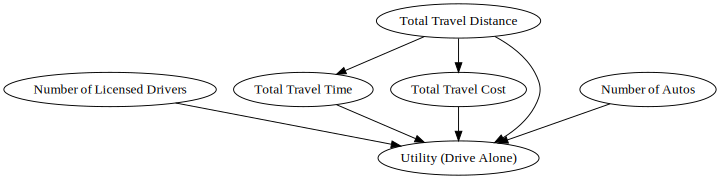

In [4]:
# Draw the causal model being tested
causal_graph = DRIVE_ALONE_UTILITY.draw()
causal_graph.graph_attr.update(size="10,6")
causal_graph

## Marginal independence tests

### Main idea
The marginal independence tests demonstrated in this notebook will visually test the following implication<br>
$
\begin{aligned}
P \left( X_1 \mid X_2 \right) &= P \left( X_1 \right) \\
\int x_1 P \left( X_1 \mid X_2 \right) \partial{x_1}  &= \int x_1 P \left( X_1 \right) \partial{x_1} \\
E \left[ X_1 \mid X_2 \right] &= E \left[ X_1 \right]
\end{aligned}
$

In other words, if $X_1$ is marginally independent of $X_2$, then the expectation of $X_1$ conditional on $X_2$ is equal to the marginal expectation of $X_1$.
Marginal independence implies mean independence.
This means that shuffling / permuting the $X_2$ columns should make no difference to predicting $X_1$, once one predicts $\bar{X_1}$.

The test demonstrated below works by estimating a linear regression to predict $E \left[ X_1 \mid X_2 \right]$.
We compute the $r^2$ from these regressions using the observed value of $X_2$ and also using the permuted values of $X_2$, which are independent of $X_1$ by construction.

If $X_1$ is marginally independent of $X_2$, then the $r^2$ using the observed values of $X_2$ should resemble the distribution of $r^2$ using the permuted values of $X_2$.

For this test, we'll use the following marginal independence assumption implied by the causal graph above:<br>
$
P \left( \textrm{Number of Automobiles} \mid \textrm{Number of licensed drivers} \right) = P \left( \textrm{Number of Automobiles} \right)
$

100%|██████████| 100/100 [00:00<00:00, 873.15it/s]

The p-value of the permutation independence test is 0.00.


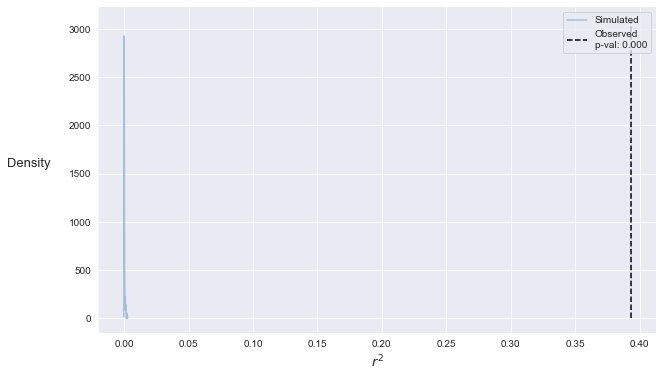

0.0

In [5]:
license_array = drive_alone_df[LICENSE_COLUMN].values
num_cars_array = drive_alone_df[NUM_AUTOS_COLUMN].values

oi.visual_permutation_test(
    license_array,
    num_cars_array,
    z_array=None,
    seed=1038,
    num_permutations=NUM_PERMUTATIONS,
    permutation_color=PERMUTED_COLOR,
)

### Caveats and pitfalls
Two important issues when testing the assumption of mean independence between $X_1$ and $X_2$ are underfitting and overfitting of the model for $E \left[ X_1 \mid X_2 \right]$.

If $E \left[ X_1 \mid X_2 \right]$ is underfit, then one's observed test statitic ($r^2$) will be lower than it would be under a correctly specified model.
This will increase the probability of Type-2 error, failing to reject the null-hypothesis when the null is false.
Underfitting reduces the power of one's predictive test.
To guard against underfitting, one should make extensive use of posterior predictive checks and model selection techniques to select the predictively most powerful models that do no show signs of overfitting.

Conversely, if $E \left[ X_1 \mid X_2 \right]$ is overfit, then one's observed test statistic ($r^2$) will be higher than it would be under a correctly specified model.
This will increase the probability of one rejecting the null-hypothesis when the null is true.
Overfitting increases the probability of Type-1 errors.
To guard against overfitting, one should make thorough use of cross-validation and related resampling techniques to ensure that one's model performance does not degrade appreciably outside of the training set.

## Conditional independence tests

### Main idea
In particular, the notebook will show one way to visually and numerically test the following implication<br>
$
\begin{aligned}
P \left( X_1 \mid X_2, Z \right) &= P \left( X_1 \mid Z \right) \\
\int x_1 P \left( X_1 \mid X_2, Z \right) \partial{x_1}  &= \int x_1 P \left( X_1 \mid Z \right) \partial{x_1} \\
E \left[ X_1 \mid X_2, Z \right] &= E \left[ X_1 \mid Z \right]
\end{aligned}
$

In other words, if $X_1$ is conditionally independent of $X_2$ given $Z$, then the expectation of $X_1$ conditional on $X_2$ and $Z$ is equal to the expectation of $X_1$ conditional on $Z$ alone.
This implies that shuffling / permuting $X_2$ should make no difference for predicting $X_1$ once we've included $Z$ while predicting.

In other words, one's ability predict to predict $X_1$ should not depend on whether one uses the original $X_2$ or the permuted $X_2$, as long as one conditions on $Z$ when predicting $X_1$.
In this notebook, we test this invariance using a simple predictive model, linear regression, but in general, one need not and should not restrict oneself to linear predictive models. Upon estimating each regression, we compare $r^2$ as a measure of predictive ability when using $Z$ and the original $X_2$ versus $r^2$ when using $Z$ and the permuted $X_2$.

For this test, we'll use the following conditional independence assumption implied by the causal graph above:<br>
$
P \left( \textrm{Travel Time} \mid \textrm{Travel Cost}, \textrm{Travel Distance} \right) = P \left( \textrm{Travel Time} \mid \textrm{Travel Distance} \right)
$

100%|██████████| 100/100 [00:00<00:00, 776.46it/s]


The p-value of the permutation independence test is 0.00.


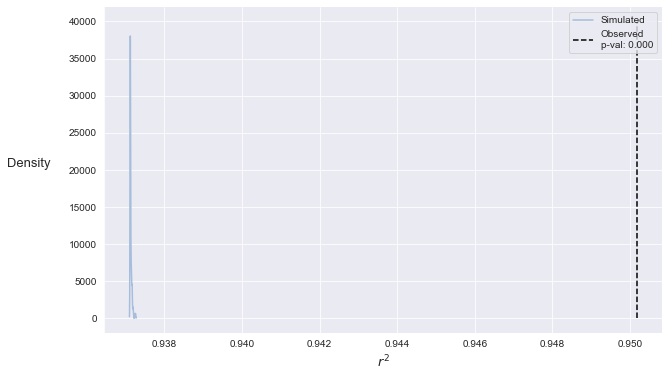

0.0

In [6]:
time_array = drive_alone_df[TIME_COLUMN].values
cost_array = drive_alone_df[COST_COLUMN].values
distance_array = drive_alone_df[DISTANCE_COLUMN].values

oi.visual_permutation_test(
    time_array,
    cost_array,
    z_array=distance_array,
    num_permutations=NUM_PERMUTATIONS,
    permutation_color=PERMUTED_COLOR,
)

### Caveats and pitfalls
When testing conditional mean independence (i.e., $E \left[ X_1 \mid X_2, Z \right] = E \left[ X_1 \mid Z \right]$), there are four potential issues of interest.

The first issue is misspecification of $E \left[ X_1 \mid Z \right]$.
If the conditional mean of $X_1$ depends on un-modeled functions of $Z$ and $Z \rightarrow X_2$, then the inclusion of $X_2$ in one's model may serve as a proxy for the un-modeled function of $Z$.
Such proxy behavior would lead one to observe "inflated" values of $r^2$ when modeling $E \left[ X_1 \mid X_2, Z \right]$, thus increasing the probability that one will reject the null-hypothesis of conditional independence when it is true.

In other words, to guard against higher-than-nominal probabilities of type-1 error, one needs to guard against underfitting of the model for $E \left[ X_1 \mid Z \right]$ **before** computing one's test-statistic and (permutation-based) reference-distribution.

The second issue is misspecification of $E \left[ X_1 \mid X_2, Z \right]$.
If one's model for $E \left[ X_1 \mid X_2, Z \right]$ is underfit with respect to $X_2$, then one's test-statistic ($r^2$) will be lower than it should be under accurate specification.
This leads to greater probability of type-2 error, i.e., failing to reject the null hypothesis when it is false.

The two overfitting issues below are the converse of the underfitting problems discussed in the last two paragraphs.
If one's model for $E \left[ X_1 \mid Z \right]$ is overfit, then the reference-distribution of the test statistic will be artificially high.
This will lead to higher probability of Type-2 error: i.e., lower probability of rejecting the null hypothesis of conditional independence when it is indeed false.
Likewise, if one's model for $E \left[ X_1 \mid X_2, Z \right]$ is overfit to $X_2$, then one's test-statistic will be artificially high, thus increasing the probability of Type-1 error--incorrectly rejecting the null-hypothesis when it is true.

To avoid all such problems or the combination of these problems, be sure to check one's models of $E \left[ X_1 \mid Z \right]$ and $E \left[ X_1 \mid X_2, Z \right]$ for both under- and over-fitting.
As mentioned above, posterior predictive checks are most helpful for identifying underfitting in one's models.
Cross-validation and resampling techniques are great for identifying overfitting.

## Latent conditional independence tests


### Show the posited causal graph
The key differences between the graph underlying the latent, conditional independence tests and the graph underlying the tests above are that, now, we posit:
1. the existence of a latent confounder
2. the conditional independence of the observed variables, given the latent confounder.

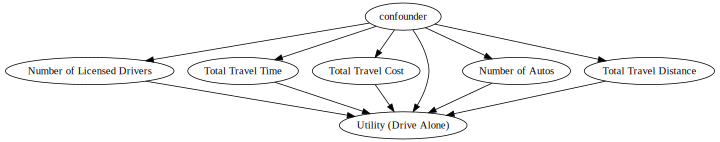

In [7]:
# Draw the causal model being tested
latent_causal_graph = LATENT_DRIVE_ALONE_UTILITY.draw()
latent_causal_graph.graph_attr.update(size="10,6")
latent_causal_graph

### Main idea
The latent, conditional independence test is a prior / posterior predictive test that involves a latent variable.

Section 2.2 of
> Gelman, Andrew, Xiao-Li Meng, and Hal Stern. "Posterior predictive assessment of model fitness via realized discrepancies." Statistica sinica (1996): 733-760.

describes these tests.

The basic idea is to select a test-statistic or discrepancy measure $D \left( \textrm{Data} ; \theta \right)$ that is a function of both the observed or simulated data and of the latent variables $\theta$.
In the test demonstrated below, $D \left( \textrm{Data} ; \theta \right)$ is the p-value resulting from the visual conditional independence function above.
This discrepancy value is an estimate of the probability that the chosen $X_1$ and $X_2$ variables are not conditionally independent given a particular vector $\theta$ of latent confounders.

The tail-area probability (i.e. the analog of the classical p-value) that corresponds to this discrepancy value is:<br>
$
P \left[ D \left( \textrm{Data}^{\textrm{rep}} ; \theta \right) \geq D \left( \textrm{Data}^{\textrm{obs}} ; \theta \right) \mid \textrm{Model}, \textrm{Data}^{\textrm{obs}} \right] =\\
\int \left[ D \left( \textrm{Data}^{\textrm{rep}} ; \theta \right) \geq D \left( \textrm{Data}^{\textrm{obs}} ; \theta \right) \mid \textrm{Model}, \textrm{Data}^{\textrm{obs}} \right] \partial P \left( \textrm{Data}^{\textrm{rep}}, \theta \mid \textrm{Model}, \textrm{Data}^{\textrm{obs}} \right)
$

In words, the demonstrated test iteratively samples the latent confounder and then simulates a dataset of replicated variables.
For each sample of the confounder and replicated dataset, we calculate the p-value of the visual, conditional independence test for both:
- the observed covariates and currently sampled confounder vector,
- the replicated dataset and currently sampled confounder vector.

The overall p-value of the latent conditional independence test is then calculated by averaging the number of times that the p-value with the replicated dataset is more extreme (i.e., greater than) than the p-value with the observed dataset.

#### Prior distribution based test

In [8]:
# Get the means and standard deviations of those variables
drive_alone_means = drive_alone_df.mean()
drive_alone_means.name = "mean"

drive_alone_stds = drive_alone_df.std()
drive_alone_stds.name = "std"

# Look at the computed means and standard deviations
print(pd.DataFrame([drive_alone_means, drive_alone_stds]).T)

                            mean        std
total_travel_time      29.667137  24.586569
total_travel_cost       3.289287   4.214448
total_travel_distance  15.579498  18.465879
num_licensed_drivers    2.178759   0.751621
num_cars                2.050999   0.880458


In [9]:
# Note the number of dimensions
num_dimensions = len(UTILITY_COLUMNS)

# Specify the prior distributions for the factor
# model of the standardized drive alone dataframe
w_dist_prior = scipy.stats.norm(loc=0, scale=1)
z_dist_prior = scipy.stats.norm(loc=0, scale=1)

sigma_prior = 0.1
epsilon_dist_prior = scipy.stats.norm(loc=0, scale=sigma_prior)

# Get samples of x from the prior distribution factor model
x_samples_prior, z_samples_prior = sample_from_factor_model(
    loadings_dist=z_dist_prior,
    coef_dist=w_dist_prior,
    noise_dist=epsilon_dist_prior,
    standard_deviations=drive_alone_stds.values,
    means=drive_alone_means.values,
    num_obs=num_drive_alone_obs,
    num_samples=NUM_PERMUTATIONS,
    num_factors=1,
    seed=721,
)

# Look at the dimensions of the prior predictive samples
print(x_samples_prior.shape)

(3804, 5, 100)



The p-value of the predictive, permutation C.I.T. is 0.99.


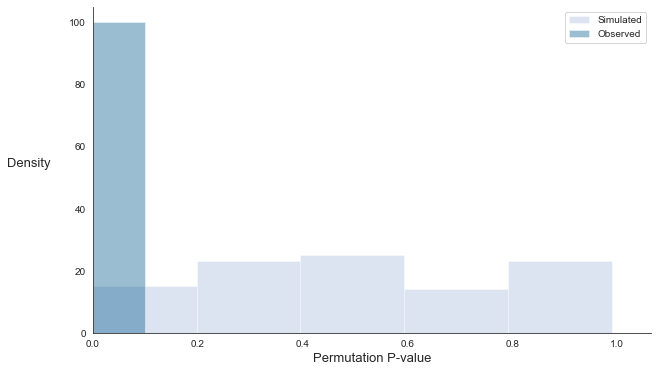

In [10]:
# Collect the columns being used in the test and info about them.
columns_for_test = [NUM_AUTOS_COLUMN, LICENSE_COLUMN]
col_idxs_for_test = [UTILITY_COLUMNS.index(col) for col in columns_for_test]

# Get the observed values to be used for testing
obs_sample = drive_alone_df.loc[:, columns_for_test].values

# Get the prior predictive values for testing
prior_samples_triplet = np.concatenate(
    (x_samples_prior[:, col_idxs_for_test, :], z_samples_prior), axis=1
)

# Use the predictive, conditional independence test
pval, sampled_pvals, obs_pvals = li.perform_visual_predictive_cit_test(
    prior_samples_triplet, obs_sample
)

#### Posterior distribution based test

In [11]:
# Load the parameters of the variational approximation to
# the posterior distribution over W and Z
w_post_params = pd.read_csv(PATH_TO_W_PARAMS, index_col=0)
z_post_params = pd.read_csv(PATH_TO_Z_PARAMS, index_col=0)

# Create the posterior distribution of coefficients
# Note we need the arguments to have shape that can,
# be broadcast to (num_factors, num_predictors, num_samples)
w_dist_post = scipy.stats.norm(
    loc=w_post_params["w_mean_inferred"].values[None, :, None],
    scale=w_post_params["w_std_inferred"].values[None:, None],
)

# Create the posterior distribution of loadings
# Note we need the arguments to have shape that can,
# be broadcast to (num_obs, num_factors, num_samples)
z_dist_post = scipy.stats.norm(
    loc=z_post_params["z_mean_inferred"].values[:, None, None],
    scale=z_post_params["z_std_inferred"].values[:, None, None],
)

# Get posterior samples of X_standardized
x_samples_post, z_samples_post = sample_from_factor_model(
    loadings_dist=z_dist_post,
    coef_dist=w_dist_post,
    noise_dist=epsilon_dist_prior,
    standard_deviations=drive_alone_stds.values,
    means=drive_alone_means.values,
    num_obs=num_drive_alone_obs,
    num_samples=NUM_PERMUTATIONS,
    num_factors=1,
    post=False,
    seed=852,
)

# Look at the dimensions of the prior predictive samples
print(x_samples_post.shape)

(3804, 5, 100)



The p-value of the predictive, permutation C.I.T. is 0.98.


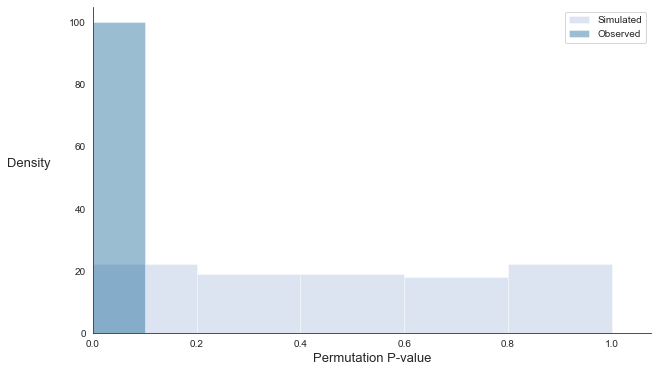

In [12]:
# Get the posterior predictive values for the test
posterior_samples_triplet = np.concatenate(
    (x_samples_post[:, col_idxs_for_test, :], z_samples_post), axis=1
)

# Test out the predictive conditional independence test
(
    post_pval,
    post_sampled_pvals,
    post_obs_pvals,
) = li.perform_visual_predictive_cit_test(
    posterior_samples_triplet, obs_sample
)

### Caveats and pitfalls

Prior


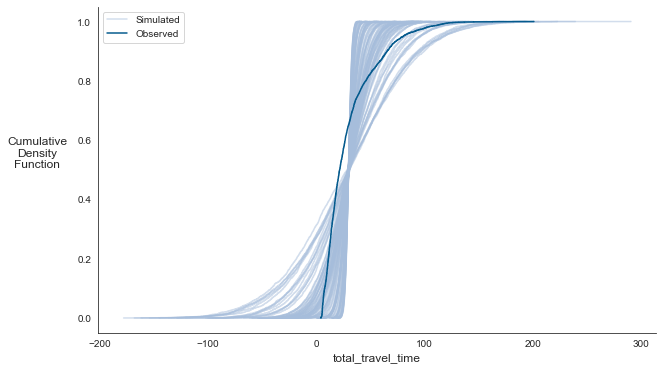

Posterior


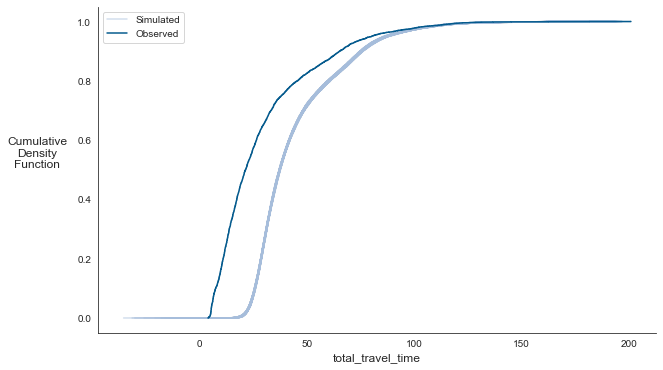

In [13]:
# Choose a column of data to compare, e.g., the
# travel time column.
current_col = TIME_COLUMN
current_col_idx = UTILITY_COLUMNS.index(TIME_COLUMN)

print("Prior")
prior_sim_cdf = li.plot_simulated_vs_observed_cdf(
    drive_alone_df.iloc[:, current_col_idx].values,
    x_samples_prior[:, current_col_idx, :],
    x_label=current_col,
)

print("Posterior")
posterior_sim_cdf = li.plot_simulated_vs_observed_cdf(
    drive_alone_df.iloc[:, current_col_idx].values,
    x_samples_post[:, current_col_idx, :],
    x_label=current_col,
)

Overall, the caveats and pitfalls only increase as one moves from marginal to conditional to latent, conditional independence tests.

When testing for latent, conditional independence, one has to be wary of the same caveats as with conditional independence: under-/overfitting of the models for $E \left[ X_1 \mid Z \right]$ and $E \left[ X_1 \mid X_2, Z \right]$.

Additionally, however, one must also be wary of any combination of:
- models for the latent confounder
- models for how the latent confounder causes the observed variables
- prior distributions for the parameters of these models
- posterior distributions for the parameters of these models
that generates unrealistic data in a prior or posterior check.
We hypothesize that if the your model and prior / posterior distribution generates data that is generally dissimilar to the observed data, then these generated datasets are unlikely to have similar conditional, mean independence measures.

## Summary
The tests performed above collectively point to a few conclusions.

1. The originally posited causal graph is strongly refuted by the available data.
This is shown by the marginal and conditional independence tests.
2. The second posited causal graph (featuring an unobserved confounder) is also refuted by the data, based on the given prior or posterior distributions for the unobserved confounder.
This is shown by the latent, conditional independence tests.
3. Checking the predictive models used in one's tests for underfitting and overfitting is noted to be important for obtaining tests with high power and low probability of Type-1 error.
4. The latent, conditional independence tests exemplifies the utility of general, prior and posterior predictive checks of one's generative model.
The resulting hypothesis is that if one's model and prior/posterior distributions indicate general data conflict, then one's latent, conditional independence tests are likely to fail with the same prior/posterior distributions.